CMAPSS 데이터셋 난이도  
FD001<FD003<FD002<FD004

이 파일에서 다뤄볼 것은 FD003이다. 두 가지 오류 모두가 있다. (Fault mode : HPC, Fan) 작동 조건은 1개이다.

FD003에서는 Fault mode를 Random Forest를 활용해 구별할 수 있기 때문에 꽤 잘 수행될 것이다.  
먼저 데이터를 읽어보자.

In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [51]:
# define filepath and files to read data
dir_path = '../CMAPSSData/'
train_file = 'train_FD003.txt'
test_file = 'test_FD003.txt'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD003.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

# check shape and inspect first few rows
print(train.shape)
train.head()

(24720, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0005     0.0004      100.0  518.67  642.36   
1        1            2     0.0008    -0.0003      100.0  518.67  642.50   
2        1            3    -0.0014    -0.0002      100.0  518.67  642.18   
3        1            4    -0.0020     0.0001      100.0  518.67  642.92   
4        1            5     0.0016     0.0000      100.0  518.67  641.68   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246  0.03   391   
1  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403  0.03   392   
2  1582.35  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901  0.03   391   
3  1585.61  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878  0.03   392   
4  1588.63  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869  0.03   392   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.11  23.3537  
1  2388  100.0  38.99  23.4491  
2  2388  100.0  38.85  23.3669  
3  2388  100.0  38.96  23.2951  
4  2388  100.0  39.14  23.4583  

[5 rows x 26 columns]

In [52]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

time_cycles
count    100.00000
mean     247.20000
std       86.48384
min      145.00000
25%      189.75000
50%      220.50000
75%      279.75000
max      525.00000

In [53]:
# inspect sensor values, specifically if there are any with near 0 standard deviation 
# (sensors readings which do not change over time hold no information)
train[sensor_names].describe().transpose()
# FD003의 센서값들 describe 확인

count         mean           std        min        25%        50%  \
s_1   24720.0   518.670000  6.684921e-11   518.6700   518.6700   518.6700   
s_2   24720.0   642.457858  5.230311e-01   640.8400   642.0800   642.4000   
s_3   24720.0  1588.079175  6.810418e+00  1564.3000  1583.2800  1587.5200   
s_4   24720.0  1404.471212  9.773178e+00  1377.0600  1397.1875  1402.9100   
s_5   24720.0    14.620000  3.602525e-12    14.6200    14.6200    14.6200   
s_6   24720.0    21.595841  1.811600e-02    21.4500    21.5800    21.6000   
s_7   24720.0   555.143808  3.437343e+00   549.6100   553.1100   554.0500   
s_8   24720.0  2388.071555  1.582849e-01  2386.9000  2388.0000  2388.0700   
s_9   24720.0  9064.110809  1.998029e+01  9017.9800  9051.9200  9060.0100   
s_10  24720.0     1.301232  3.484849e-03     1.2900     1.3000     1.3000   
s_11  24720.0    47.415707  3.000742e-01    46.6900    47.1900    47.3600   
s_12  24720.0   523.050873  3.255314e+00   517.7700   521.1500   521.9800   
s_13  24720.0  2388.071643  1.581207e-01  2386.9300  2388.0100  2388.0700   
s_14  24720.0  8144.202916  1.650412e+01  8099.6800  8134.5100  8141.2000   
s_15  24720.0     8.396176  6.051161e-02     8.1563     8.3606     8.3983   
s_16  24720.0     0.030000  1.750371e-14     0.0300     0.0300     0.0300   
s_17  24720.0   392.566545  1.761459e+00   388.0000   391.0000   392.0000   
s_18  24720.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  24720.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  24720.0    38.988552  2.488647e-01    38.1700    38.8300    38.9900   
s_21  24720.0    23.393024  1.492338e-01    22.8726    23.2962    23.3916   

            75%        max  
s_1    518.6700   518.6700  
s_2    642.7900   645.1100  
s_3   1592.4125  1615.3900  
s_4   1410.6000  1441.1600  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    556.0400   570.4900  
s_8   2388.1400  2388.6000  
s_9   9070.0925  9234.3500  
s_10     1.3000     1.3200  
s_11    47.6000    48.4400  
s_12   523.8400   537.4000  
s_13  2388.1400  2388.6100  
s_14  8149.2300  8290.5500  
s_15     8.4370     8.5705  
s_16     0.0300     0.0300  
s_17   394.0000   399.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    39.1400    39.8500  
s_21    23.4833    23.9505

In [54]:
# FD003 train set의 RUL 계산
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  258
1        1            2  257
2        1            3  256
3        1            4  255
4        1            5  254

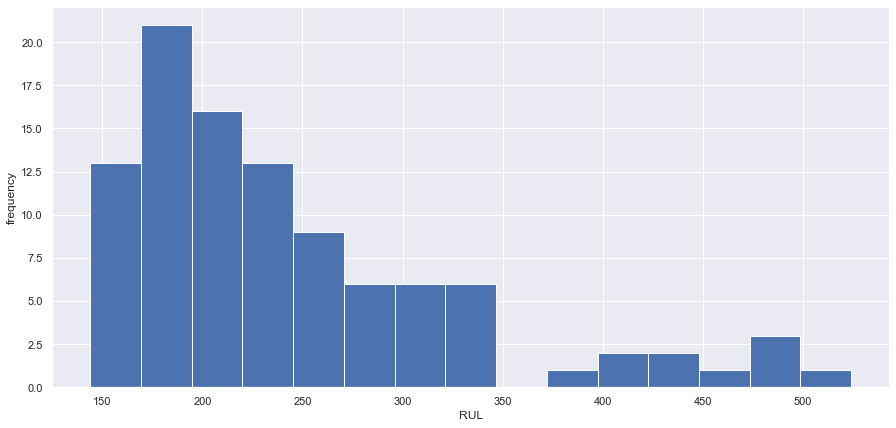

In [55]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()
# RUL의 분포 보기

RUL은 300 이하인 경우가 많다. 500 400 등 RUL 이 높은 경우는 거의 없다.  
치우친 분포는 모델 성능에 큰 영향을 미칠 수 있다.  
계산된 RUL을 모델 훈련을 위해 상한선인 125로 clipping 할 것이다.

그 다음 FD003에서 버릴 센서들을 고를 것이다.  
그러기 위해 RUL이 변해도 변하지 않는 센서값, 이상치 등을 보자.

In [56]:
train['unit_nr'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

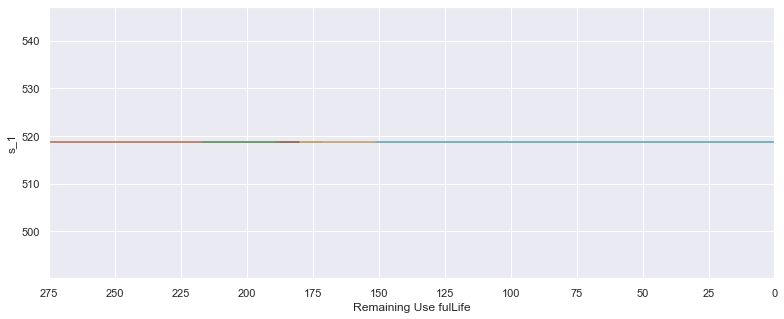

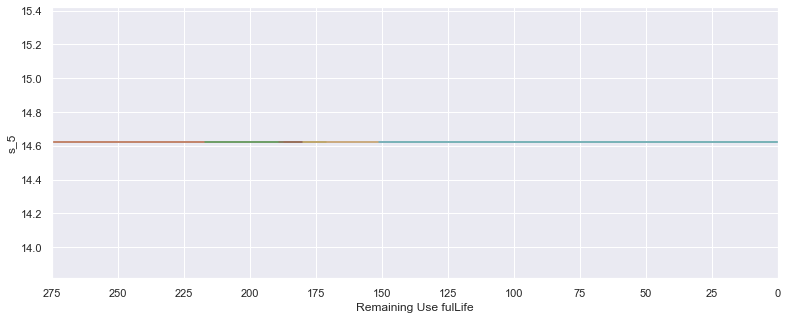

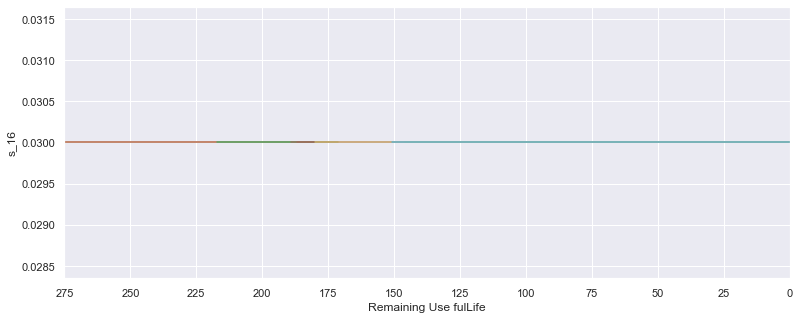

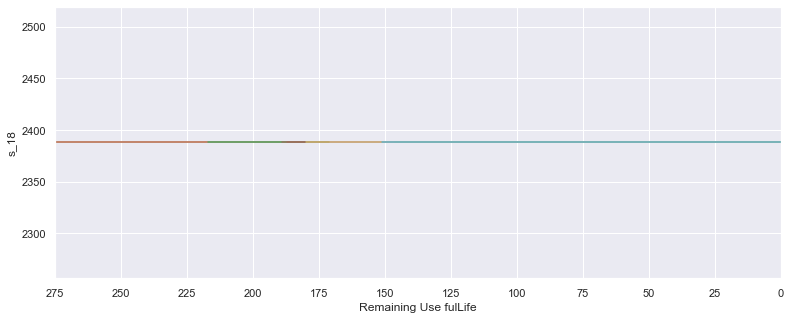

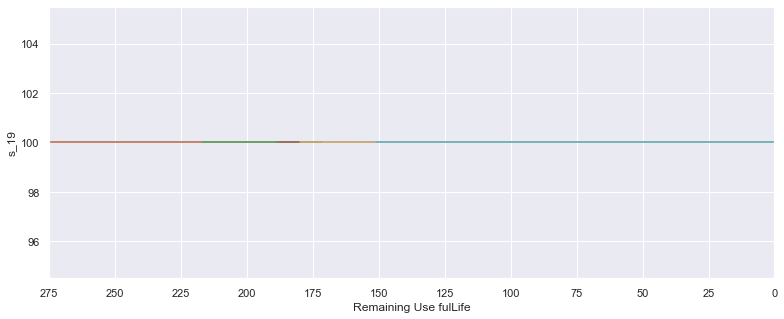

In [57]:

def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_nr'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, 
                     data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor in ['s_1','s_5','s_16','s_18','s_19']: # 아무 변화도 없는 센서
    plot_signal(train, sensor)

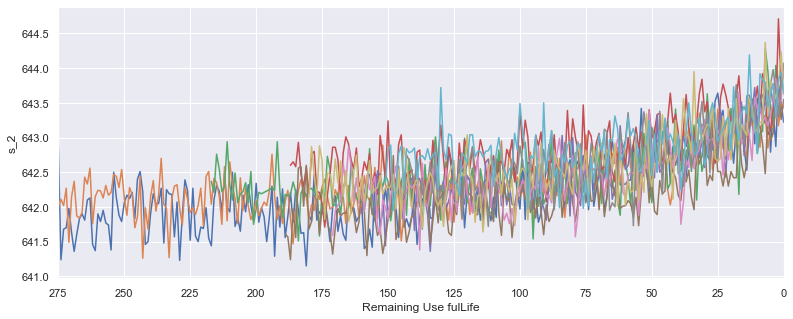

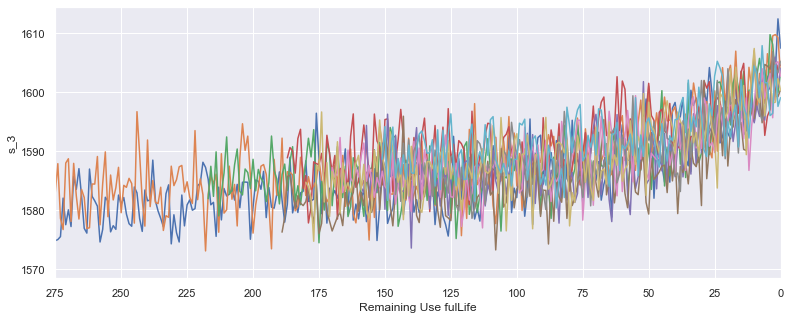

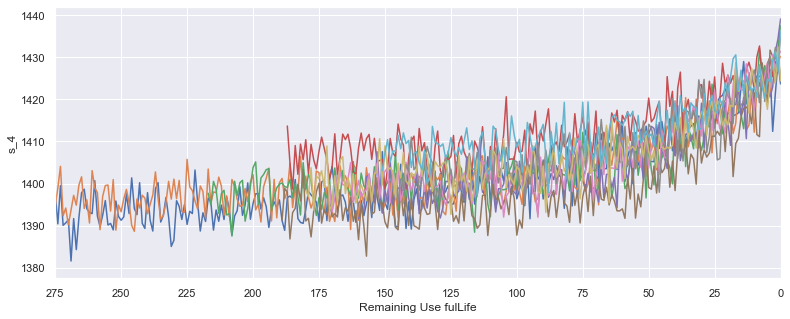

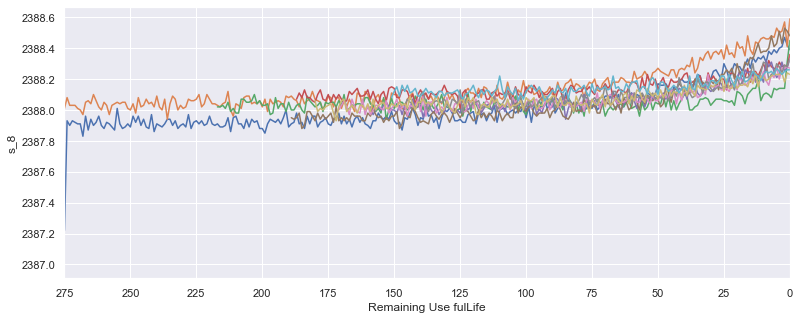

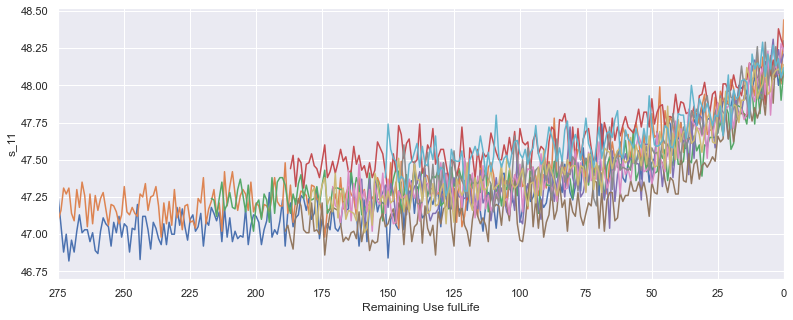

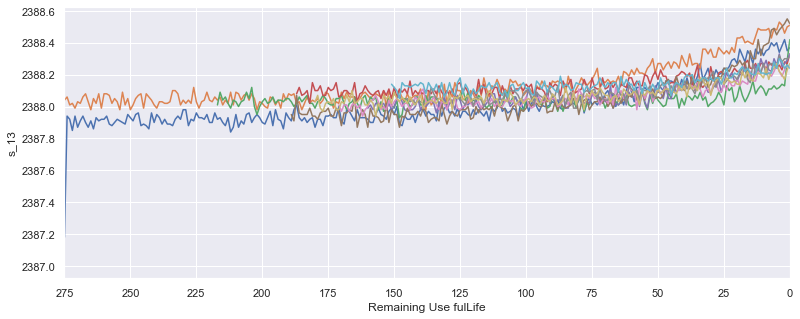

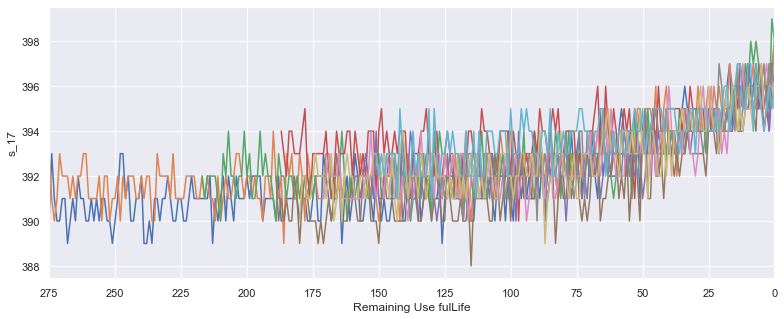

In [58]:
for sensor in ['s_2','s_3','s_4','s_8','s_11','s_13','s_17']: # 상승 추세!
    plot_signal(train, sensor)

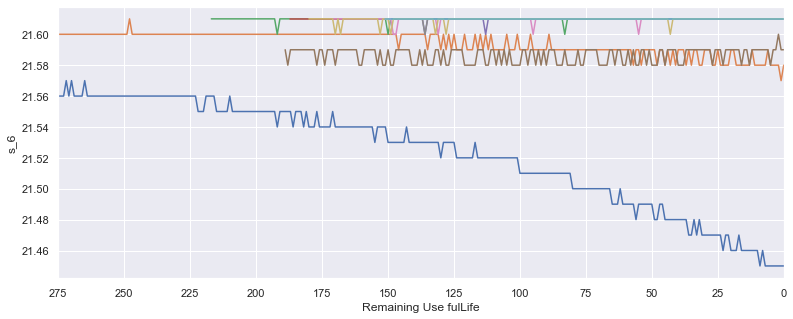

In [59]:
for sensor in ['s_6']: # 이상치
    plot_signal(train, sensor)

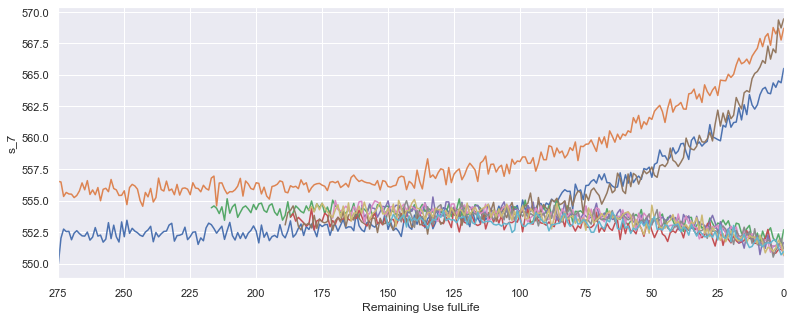

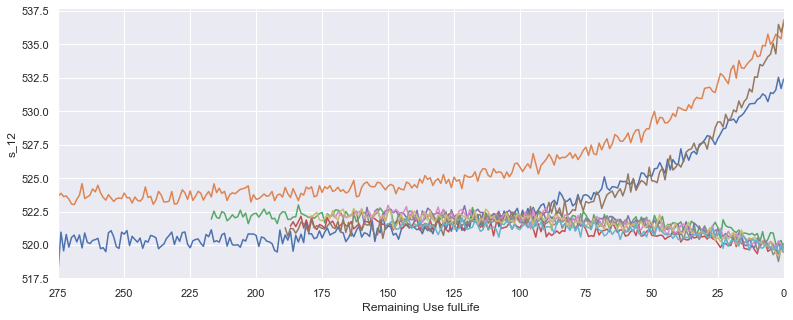

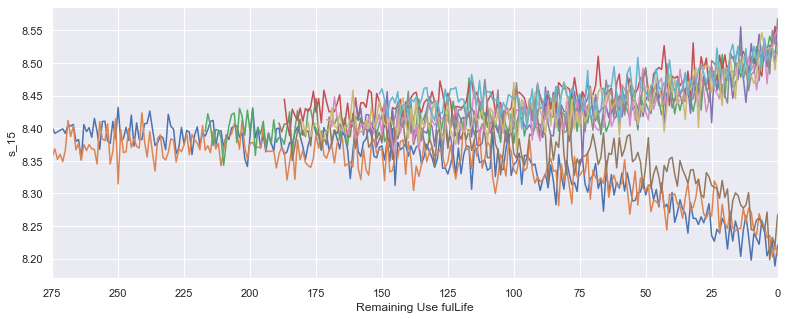

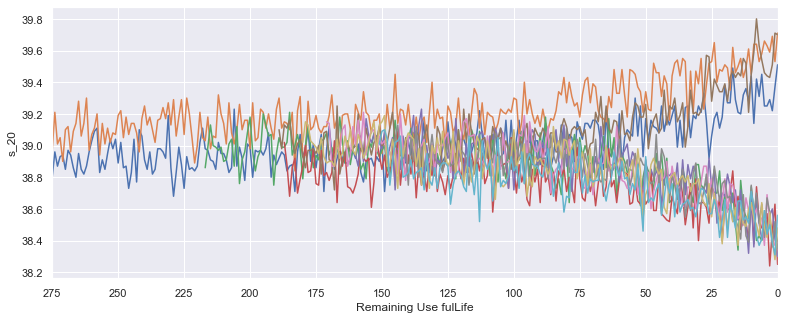

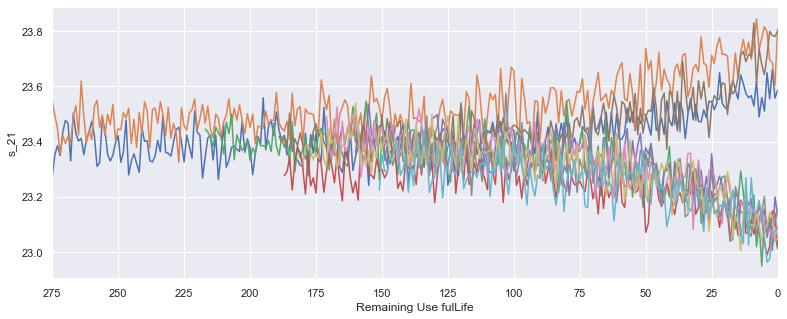

In [60]:
for sensor in ['s_7','s_12','s_15','s_20','s_21']: # 두 가지 오류모드(Fault mode)를 명확히 보여줌! 
    # 반드시 모델에 포함해야 함. (unit에 따라 두 갈래로 나뉘는 모습)
    plot_signal(train, sensor)

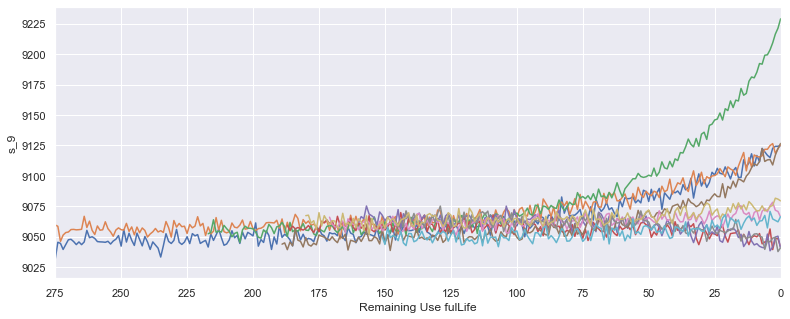

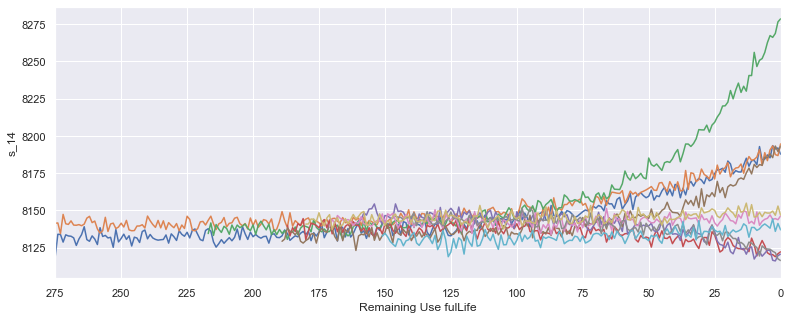

In [61]:
for sensor in ['s_9','s_14']: # Fault mode도 비슷하게 생겼으나, 2갈래로 나뉘지 않고
    # 더 여러 갈래로 나뉨 .. Fault mode를 잘 구분하지 못한다.
    # 모델 성능에 미치는 영향을 테스트하려면 포함해야할지를 결정 해봐야 함.
    plot_signal(train, sensor)

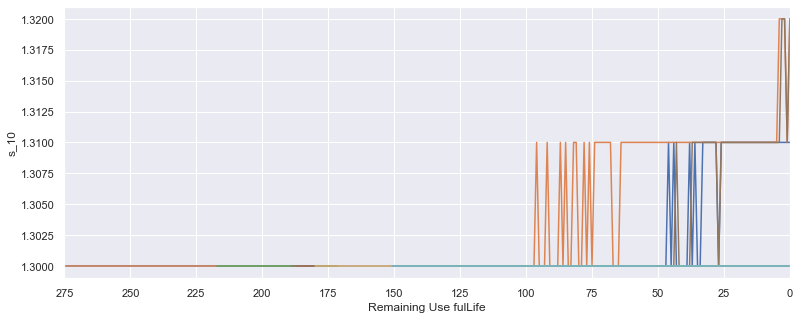

In [62]:
for sensor in ['s_10']: # 약간의 상승 추세가 있는 것 같으나 이상하다.
    plot_signal(train, sensor)

그럼 이제 기준 모델을 정해보자.  
가능한 간단한 모델인, 추가 전처리가 없는 회귀 모델에서 시작하는 것이 좋다.

In [63]:
# 데이터 준비, 센서 버릴 것만 버리고 특별히 다른 건 안함.
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']  # s_6,s_10은 의심의 이득은 있다.
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier posts

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [64]:
# evaluate - mse, rmse, r2 score로 모델의 회귀 예측값과 실제 정답으로 variance 구함
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [65]:
# 가장 기본적인 선형 회귀로 FD003을 시작하자. 
lm = LinearRegression()
lm.fit(X_train, y_train) # 그리고 fitting

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:63.49447192183344, R2:0.5873657567234001
test set RMSE:57.05730530065101, R2:-0.8998253079787795


엥.. 원래는 22.319 test RMSE로 나와야되는데 너무 크게 나왔다 뭔가 이상한데  
아무튼 여기서 더 낮춰보자. 먼저 Random Forest Regressor를 사용해보자.

### 랜덤 포레스트
단일 결정 트리에 비해 랜덤 포레스트(RF)가 가지는 주요 장점 중 하나는  
다양한 트리를 생성하는 능력이다.  
단일 의사 결정 트리를 생성할 때 알고리즘은 데이터세트를 가장 잘 분할하는  
단일 feature(사용가능한 모든 feature들 중)을 기반으로 의사 결정 노드를 생성하는 것이다.  
다음 노드의 경우 사용 가능한 모든 feature를 다시 검사하여 최상의 분할을 생성한다.  

이런 조건에서 두 번째로 의사결정트리를 적합하게 하면 정확히 동일한 트리가 된다.  

그러나 RF는 분할을 생성할 때 모든 feature의 하위 set만 고려한다.  
이렇게 하면 최상의 분할을 생성하는 기능을 사용하지 못할 수 있으므로  
알고리즘이 다른 트리를 만들도록 한다.  
따라서 더 나은 성과를 내는 '분할 조합'을 생각해낼 수 있다.

sklearns의 RandomForestRegressor에서는 기본적으로 모든 feature을 고려하여  
기본적으로 동일한 트리를 계속해서 생성하는 것으로 나타났다.  
따라서 max_features를 사용 가능한 feature의 제곱근으로 지정한다.  
또한 트리가 항상 같은 방식으로 생성되도록 random_state를 설정했다.  
그렇지 않으면 무작위 트리 생성이 모델 결과에 영향을 미치므로   
일부 feature를 변경했거나 무작위로 인해 모델이 더 나은 성능을 발휘하는지 판단하기 어려움.

In [66]:
from sklearn.ensemble import RandomForestRegressor

# bare random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:5.9199939580022525, R2:0.9787661901585051
test set RMSE:21.05308450085165, R2:0.7413439613827657


원래 일반 Linear Regressor는 RMSE가 22이므로 RF는 약간 더 나은정도 성능을 보여준다.  
하지만 RMSE 차이와 훈련세트,테스트세트 간의 분산으로 보건데  
모델이 상당히 과적합되어있다.  

따라서 몇 가지 나무의 특성을 조사해보자. Tree.estimators 로 확인해본다

In [67]:
# single 트리의 레이아웃을 몇 가지 확인한다.
print(rf.estimators_[5].tree_.max_depth)  # check how many nodes in the longest path
rf.estimators_[5].tree_.n_node_samples    # check how many samples in the last nodes

33


array([15616, 11694,  7793, ...,     1,     1,     4], dtype=int64)

이 트리의 가장 긴 경로(path)는 33개의 노드로 이뤄져 있으며, 우리가 넣은 feature 수의 두 배 이상이다.  
n_nodes_samples를 볼 때 트리의 마지막 잎에는 각각 매우 적은 수의 샘플(1,1,4)가 포함되어 있음을   
알 수 있다.  
트리가 너무 구체적이어서 대부분의 샘플을 구별할 수 있을 때까지 분할 기준을 만들었다.  
-> Overfitting 되었다는 소리.
RF의 max_depth 및 min_samples_leaf를 설정하여 이 문제를 해결할 수 있다.

In [68]:
# RF의 overfitting을 보완하기 위해 max_depth와 min_samples_leaf 추가
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.706704198492831, R2:0.8505294865338602
test set RMSE:20.994958823842456, R2:0.7427702419664686


오케이! 약간의 성능 향상 (20.99로)를 얻으며 overfitting을 줄일 수 있었따(test set과 train set의 차이)  
제거했던 센서들(불필요 센서)는 그대로 유지하고 진행하였다.
자 이제 저 RF 모델을 Base Model로 사용하여 추가 개선을 진행해보자!

In [78]:
# RF 시각화! 트리의 좋은 점은 설명력이 좋다는 점
from subprocess import call
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

def export_rf_visual(estimator, file_name, dpi):
    # create visualization of decesion tree
    tree = export_graphviz(estimator, 
       out_file=f'{file_name}.dot', 
       feature_names=X_train.columns, # column names
       filled=True,        
       special_characters=True, 
       rotate=True)

    # Convert to png using system command (requires Graphviz)
    # call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
    # due to the use of a virtual environment and some laptop settings I had to alter the command slightly

    # 원본 코드
    call(['C:/Users/USER/anaconda3/envs/rul/Lib/site-packages/graphviz/dot.exe', '-Tpng', 
          f'{file_name}.dot', '-o', f'{file_name}.png', f'-Gdpi={dpi}'])
    print(f'estimator succesfully exported to: {file_name}.png')

    # 수정 코드
    # with open (f'./{file_name}.dot','r',encoding='UTF-8') as f:
    #     dot_graph = f.read()
    # dot = graphviz.Source(dot_graph)
    # dot.format = 'png'
    # dot.render(filename='FD003_tree',directory = './', cleanup=False)
    # return


# Export and display in jupyter notebook
file_name = 'FD003_tree'
export_rf_visual(rf.estimators_[5], file_name, dpi=200)
Image(filename = f'{file_name}.png')

estimator succesfully exported to: FD003_tree.png


tree를 graphviz로 시각화하면 아래와 같이 트리구조를 보여준다.
의사결정 트리의 일부인 이 시각화는 RF의 단일 트리만 나타낸다.

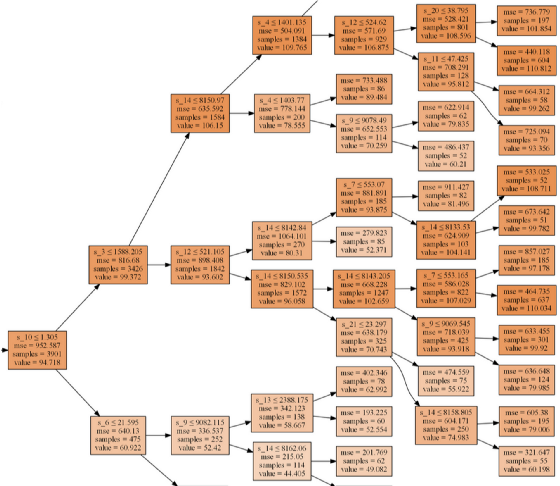

In [ ]:
from IPython.display import Image
Image("./FD003_tree.png")

트릭 구조를 봤을 때 매우 부정확한 예측을 초래하는 일부 노드가 있는 것 같다.  
(mse>500)   
Fault mode를 잘 구별하지 못하는 s_9,s_14 때문에 결과가 미약한 것인 것 같다.  
두 센서를 drop하고 RF에 성능을 확인해보자

In [79]:
# 쓸 센서 재정의
drop_sensors = ['s_1','s_5', 's_9', 's_14', 's_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_10',
       's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)

X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [80]:
# 다시 확인
# RF의 overfitting을 보완하기 위해 max_depth와 min_samples_leaf 추가
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:17.598192835079978, R2:0.8123616776758054
test set RMSE:22.186214762363356, R2:0.7127516253047333


으음.. 더 성능이 나빠졌다.. 그냥 9랑 14는 포함하자

In [81]:
# 데이터 준비, 센서 버릴 것만 버리고 특별히 다른 건 안함.
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']  # s_6,s_10은 의심의 이득은 있다.
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier posts

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [82]:
# 다시 확인
# RF의 overfitting을 보완하기 위해 max_depth와 min_samples_leaf 추가
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.706704198492831, R2:0.8505294865338602
test set RMSE:20.994958823842456, R2:0.7427702419664686


그냥 다시 s_9, s_14를 놔두기로 했다.

### 피처 엔지니어링
이 특정 데이터셋(알고리즘 조합)에 대한 feature 엔지니어링의 가능성은 많지 않다.  
RF는 복잡한 데이터 패턴을 학습하는 데 탁월하며 크기 조정 또는 feature 변환에 불변하다.  
모든 feature 가 이미 숫자이기 때문에 더 이상 할 수 있는 일이 없다.

-> 단순 이동 평균으로 데이터를 smoothing 해보았다.  
이론적으로 이건 알고리즘이 분할을 올바르게 적용하는 것을 더 쉽게 만들고,  
신호에서 잡음이 제거될 때 결함을 더 쉽게 구별할 수 있도록 한다.  

In [83]:
# smoothing
def smooth(df, sensors, n_samples):
    # first, take the rolling mean for
    df[sensors] = df.groupby('unit_nr')[sensors].rolling(n_samples).mean().reset_index(drop=True)
    
    # second, drop introduced Na's
    # https://stackoverflow.com/questions/31226142/python-pandas-delete-the-first-row-by-group
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples+1] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    # third, update column names
    df.columns = df.columns.str.replace('s_', 'sma_')
    smooth_sensors = [string.replace('s_', 'sma_') for string in sensors]  # create seperate list for later use   
    return df, smooth_sensors

In [84]:
# train set에 smoothing 적용
train_smooth = train.copy()
train_smooth.drop(drop_sensors+setting_names, axis=1, inplace=True)
train_smooth, smooth_sensors = smooth(train_smooth, remaining_sensors, 15)

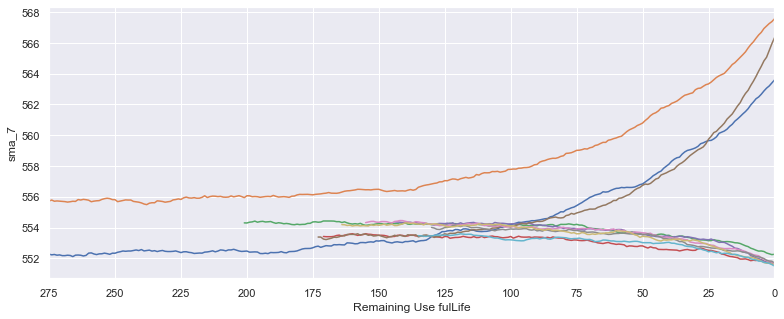

In [85]:
plot_signal(train_smooth, 'sma_7')

In [86]:
# test set에 smoothing 적용
test_smooth = test.copy()
test_smooth.drop(drop_sensors+setting_names, axis=1, inplace=True)
test_smooth, _ = smooth(test_smooth, remaining_sensors, 15)

In [89]:
X_train_smooth = train_smooth[smooth_sensors]
y_train_clipped_smooth = train_smooth['RUL'].clip(upper=125)  
# we haven't really smoothed the RUL values, but it helps to distinguish it from the original

X_test_smooth = test_smooth.groupby('unit_nr').last().reset_index().drop(index_names, axis=1)

In [90]:
# 난잡하게 만들어진 기본적인 RF에 smoothed sensors 적용
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train_smooth, y_train_clipped_smooth)

# predict and evaluate
y_hat_train = rf.predict(X_train_smooth)
evaluate(y_train_clipped_smooth, y_hat_train, 'train')

y_hat_test = rf.predict(X_test_smooth)
evaluate(y_test, y_hat_test)

train set RMSE:14.83067359916992, R2:0.8698238581213786
test set RMSE:21.786800305689553, R2:0.7230010898941535


으음.. 적용해봤는데 안타깝게도 RMSE의 개선은 없었다.

### 하이퍼파라미터


In [91]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

RF를 피팅할 때 가장 큰 문제는 Overfitting이다. 매개변수 max_depth, min_samples_leaf, ccp_alpha  
및 min_impurity_decrease는 Overfitting을 줄이고
전반적으로 더 나은 모델 성능을 달성할 수 있게 해준다.

### ccp 알파
cost complexity pruning은 tree pruning에 쓰이는 매개변수이다.
pruning은 fitting 후 노드를 제거하는 것이므로, 기본적으로 ccp_alpha는 Overfitting을 방지하기 위해  
min_samples 및 max_depth를 사용하는 대안이다.  

노드의 cost compleixty 는 fitting 된 트리에서 검색할 수 있다.  
-> ccp_alpha가 낮을 수록 cost complexity 는 높아진다.  
작은 ccp_alpha가 있는 노드를 제거하면 트리가 정리되고 전체 복잡성이 감소한다.  

하이퍼파라미터 조정에 사용할 ccp_alpha의 범위를 표시하려면 유효 알파 대 leaf의 불순물을 시각화하는 것이 좋다.  
아래 단일 트리 RF 분석을 해보자.  


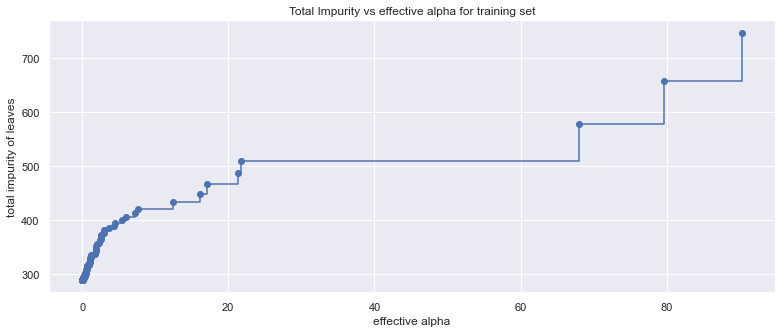

In [92]:
# get ccp_alphas
path = rf.estimators_[5].cost_complexity_pruning_path(X_train, y_train_clipped)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(13,5))
# the root node of the tree (indexed with [:-1]) is left out of the analysis, as without it there wouldn't be a tree
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

총 leaf 불순물 대 유효 알파 그래프이다.  
트리의 비용 복잡도(cost complexity)는 유효 알파가 70아래에서 20보다 약간 높을 때 실제로 증가하지만 알파 값이 낮으면 비용 복잡도가 leaf 불순물에 미치는 영향을 보기는 어렵다.  
더 확대해서 보자.

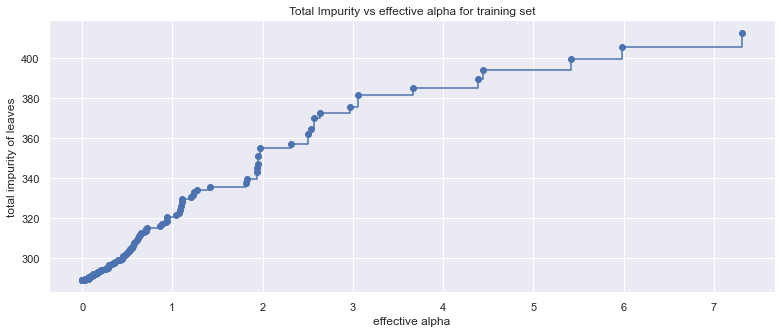

In [93]:
# zoom in
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(ccp_alphas[:-10], impurities[:-10], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

유효 알파가 2에서 0으로 떨어지고 비용 복잡성이 최대에 도달하면 leaf 불순물이 약 50 포인트 감소하는  
것으로 보이며 이는 7정도 train RMSE에 해당한다.  
첫 번째 RF의 극단적인 Overfitting을 감안할 때 이 하이퍼파라미터 조정은 적합한 것 같다.

### 최소 불순물 감소
최소 불순물 감소는 분할 후 오류 감소를 나타내는 척도.  
불순물 감소는 이 식으로 계산된 가중 값이다.  

N_t / N * (impurity - N_t_R / N_t * right_impurity
                    - N_t_L / N_t * left_impurity)

여기서 N는 총 샘플 수, N_t는 현재 노드의 샘플 수, N_t_L은 왼쪽 child node의 샘플 수, N_t_R은   오른쪽 child node의 샘플 수이다.

N, N_t, N_t_R, N_t_L 모두 sample_weight가 통과된 weighted sum이다.  


불순물 감소는 일반적으로 단일 의사 결정 트리에 대해 계산된다.  
그럼 먼저 단일 트리에서 필요한 데이터를 추출해보자.  

In [94]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
import sklearn
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [95]:
rf_dict = {
    'id_node': list(range(rf.estimators_[5].tree_.node_count)),
    'impurity': rf.estimators_[5].tree_.impurity,
    'samples': rf.estimators_[5].tree_.n_node_samples,
    'id_left_child': rf.estimators_[5].tree_.children_left,
    'id_right_child': rf.estimators_[5].tree_.children_right
}

impurity_df = pd.DataFrame(rf_dict)
print(impurity_df.shape)
impurity_df.head(10)

(265, 5)


id_node     impurity  samples  id_left_child  id_right_child
0        0  1705.568223    14603              1             172
1        1   718.444699    11396              2              95
2        2   296.430869     7801              3              56
3        3   166.171633     5631              4              31
4        4    59.471469     2577              5              20
5        5    12.919173     1485              6              13
6        6     4.322259     1108              7              10
7        7    12.950452      357              8               9
8        8    40.169375       50             -1              -1
9        9     7.440176      307             -1              -1

left child, right child_id 값이 -1 인걸로 보아 부모 노드가 리프 노드였으므로 더 이상 분할이 이뤄지지 않았음을 의미.
위에 적었던 공식을 사용해 min_impurity_decrease를 계산할 수 있다.

<AxesSubplot:ylabel='Frequency'>

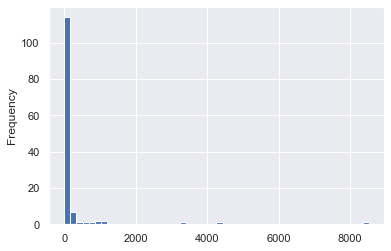

In [97]:

impurity_df['impurity_decrease'] = np.nan
samples_total = rf.estimators_[5].tree_.node_count

for idx in impurity_df.index[1:]:  # skip the first node, there aren't any splits prior to it
    if impurity_df.iloc[idx]['id_left_child'] == -1:
        continue  # we can't calculeate impurity decrease for leave nodes, as they no longer split
    else:
        impurity_P, samples_P = impurity_df.iloc[idx][['impurity', 'samples']]
        id_L, id_R = impurity_df.iloc[idx][['id_left_child', 'id_right_child']].astype(int)
        impurity_L, samples_L = impurity_df.iloc[id_L][['impurity', 'samples']]
        impurity_R, samples_R = impurity_df.iloc[id_R][['impurity', 'samples']]
        
        impurity_decrease = samples_P / samples_total * (
            impurity_P - samples_R / samples_P * impurity_R - 
            samples_L / samples_P * impurity_L
            )
        impurity_df.at[idx, 'impurity_decrease'] = impurity_decrease


# min impurity에 대한 시각화
impurity_df['impurity_decrease'].plot(kind='hist', bins=50)

시각화 결과를 보면 불순물 감소는 매우 0에 가까이 치우쳐져 있으며 이는 트리의 처음 몇 개의 노드가 오류 감소에 크게  
기여하는 것으로 설명할 수 있다.

### 랜덤 서치
Random Forest 모델에서 하이퍼파라미터를 좋게 선정하기 위해 진행하는 기법인 것 같다.

In [99]:
max_depth = [None] + list(range(3, 34, 3))  # max depth of the first RF was 33, I don't expect we need bigger depth
min_samples_leaf = list(range(1, 102, 10))  # with crude tweaking we set this to 50, for grid search I'll allow double
min_impurity_decrease = list(np.arange(0,147)/10)  
ccp_alpha = list(np.round(np.linspace(0, 2, 81), decimals=3))  

parameters = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'ccp_alpha': ccp_alpha
}

tuning_options = len(max_depth) * len(min_samples_leaf) * len(min_impurity_decrease) * len(ccp_alpha)
print(tuning_options)

# 이 결과로 나온 150만개는 하이퍼파라미터 가능한 조합의 경우의 수이다. 
# Random Search는 어떻게 보면 살짝 무식한 방법이다.
# EDA를 참고한 원작 블로그에서 미리 좋은 조합을 찾았다.

1571724


### 검증
훈련 세트에 포함된 데이터는 검증 세트에 포함되면 안된다. 그 반대도 절대 안된다.  
train:valid split은 주로 8:2 등으로 진행하며,   
검증 세트에 속하는 데이터에 무작위 분할을 진행한다.  
그러나 unit_nr을 고려하지 않고 무작위로 분할하면 train과 valid에서 단일 엔진 데이터의 일부가 남을 수 있다.  

이러한 Data Leakage를 방지하렴녀 단일 엔진의 모든 레코드가 train 또는 valid에 할당되었는지 확인해야 한다.
-> GroupKFold를 사용

In [100]:

from sklearn.model_selection import RandomizedSearchCV, GroupKFold

ITERATIONS = 300

rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
gkf = GroupKFold(n_splits=3) # GroupKFold


regressor = RandomizedSearchCV(rf, 
                               parameters, 
                               cv = gkf.split(train, groups=train['unit_nr']),
                               verbose=2, 
                               error_score='raise',
                               n_iter=ITERATIONS, 
                               n_jobs=-2,
                               # scoring https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                               scoring= 'neg_root_mean_squared_error')  
regressor.fit(X_train, y_train_clipped)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001F0305B4148>,
                   error_score='raise',
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   random_state=42),
                   n_iter=300, n_jobs=-2,
                   param_distributions={'ccp_alpha': [0.0, 0.025, 0.05, 0.075,
                                                      0.1, 0.125, 0.15, 0.175,
                                                      0.2, 0.225, 0.25, 0.275,
                                                      0.3, 0.325, 0.35, 0.375,
                                                      0.4, 0.425, 0.45, 0.475,
                                                      0.5, 0.525, 0.55, 0.575,
                                                      0.6, 0.625, 0.65, 0.675,
                                                      0.7, 0.725, ...],
                                        'max_depth': [None, 3, 6, 9, 12

불행히도 결과를 재현할 수 없다.    
즉, 커널을 다시 시작하고 노트북을 다시 실행해도 동일한 결과가 생성되지 않는다.   
검색을 몇 번 실행한 결과, 내가 찾은 최고 성능의 매개변수 세트는 다음과 같다.

{'min_samples_leaf': 11, 'min_impurity_decrease': 0.0, 'max_depth': 15, 'ccp_alpha': 0.125}.

이렇게 찾은 하이퍼파라미터 조합으로 최종 모델을 훈련시키자.

### 최종 모델 훈련

In [101]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42,
                           min_samples_leaf=11, min_impurity_decrease=0.0, 
                           max_depth=15, ccp_alpha=0.125)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:13.95446880579081, R2:0.8820190156933622
test set RMSE:20.61288923394374, R2:0.7520472702746352
